# Multivariate time series analysis for predictig bike share demand

DATA SOURCE https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset

## Imports

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
import seaborn as sns

# Loading data

In [ ]:
url = 'https://raw.githubusercontent.com/Apress/artificial-neural-networks-with-tensorflow-2/main/ch11/london_merged.csv'
df = pd.read_csv(url,parse_dates=['timestamp'], index_col="timestamp")

In [ ]:
df  

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0


In [ ]:
df.dtypes 

cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

# Coint Johansen Test for Stationarity

In [ ]:
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
johan_test_temp = df
coint_johansen(johan_test_temp,-1,1).eig

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


array([2.61219379e-01, 1.31970167e-01, 5.22046139e-02, 4.19830465e-02,
       2.10126207e-02, 1.75450605e-02, 1.36518877e-02, 6.26085775e-04,
       7.56291478e-05])

# Explorig data
Exploring bike count over the entire period

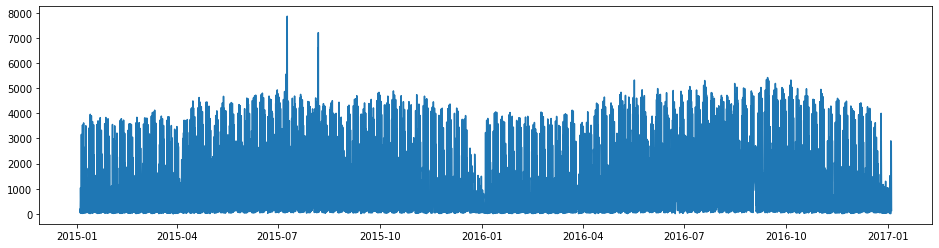

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(df.index, df["cnt"]);

In [ ]:
# create indexes
df['hour'] = df.index.hour
df['month'] = df.index.month

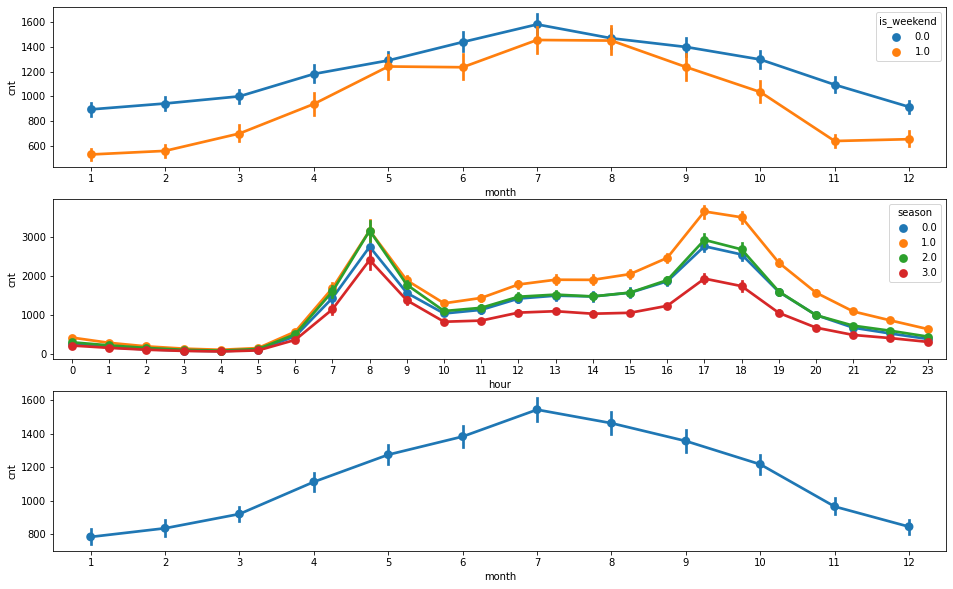

In [ ]:
fig,(ax1, ax2, ax3)= plt.subplots(nrows=3)
fig.set_size_inches(16, 10)

sns.pointplot(data=df, x='month', y='cnt', hue='is_weekend', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax2);
sns.pointplot(data=df, x='month', y='cnt', ax = ax3)

# Preparing data

In [ ]:
# scaling numeric columns
scaler = sklearn.preprocessing.MinMaxScaler()
df['t1'] = scaler.fit_transform(df['t1'].values.reshape(-1,1))
df['t2'] = scaler.fit_transform(df['t2'].values.reshape(-1,1))
df['hum'] = scaler.fit_transform(df['hum'].values.reshape(-1,1))
df['wind_speed'] = scaler.fit_transform(df['wind_speed'].values.reshape(-1,1))
df['cnt'] = scaler.fit_transform(df['cnt'].values.reshape(-1,1))

In [ ]:
# use 90% for training
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
# create input tensors
time_steps = 10
X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

In [ ]:
batch_size  = 256
buffer_size = 1000

train_data = tf.data.Dataset.from_tensor_slices((X_train , y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
test_data = tf.data.Dataset.from_tensor_slices((X_test , y_test))
test_data = test_data.batch(batch_size).repeat() 

# Building model

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape = X_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])
simple_lstm_model.compile(optimizer = 'adam', loss = 'mae')

# Training

In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

history = simple_lstm_model.fit(train_data, 
                                epochs = EPOCHS,
                                steps_per_epoch = EVALUATION_INTERVAL,
                                validation_data = test_data,
                                validation_steps = 50)

Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1176 - val_loss: 0.0820
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0744 - val_loss: 0.0594
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0631 - val_loss: 0.0540
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0574 - val_loss: 0.0481
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0527 - val_loss: 0.0472
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0493 - val_loss: 0.0446
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0466 - val_loss: 0.0439
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0448 - val_loss: 0.0391
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0433 - val_loss: 0.0396
Epoch 10/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0416 - val_loss: 0.0400

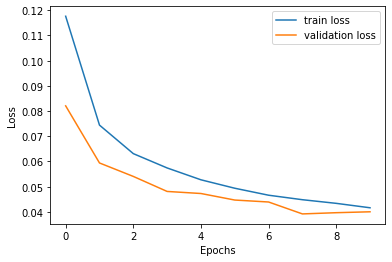

In [ ]:
# plot losses
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Evaluation

In [ ]:
X_test,y_test = create_dataset(df,df.cnt,10)
y_pred = simple_lstm_model.predict(X_test)

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

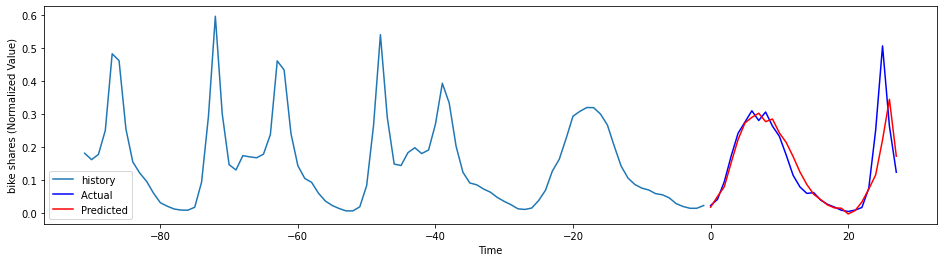

In [ ]:
plt.figure(figsize=(16,4))
num_in = create_time_steps(91)
num_out = 28
plt.plot(num_in,y_train[15571:],label='history')
plt.plot(np.arange(num_out),y_test[15661:15689], 'b',label='Actual ')
plt.plot(np.arange(num_out),y_pred[15661:15689], 'r',label='Predicted')
plt.xlabel("Time")
plt.ylabel("bike shares (Normalized Value)")
plt.legend()
plt.show()

### Predicting future point

In [ ]:
y_pred = simple_lstm_model.predict(X_test[-1:])

In [ ]:
# print value
y_pred

array([[0.02166439]], dtype=float32)

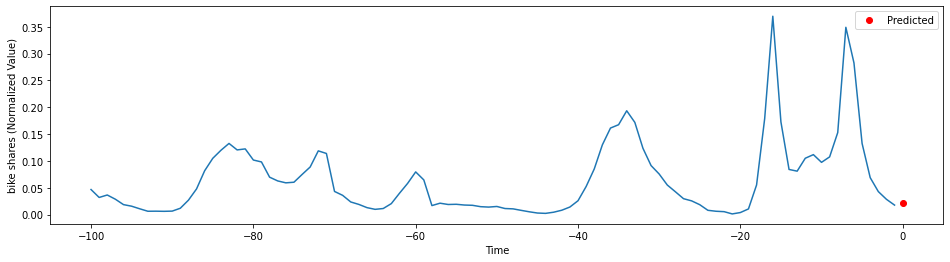

In [ ]:
# plot prediction
plt.figure(figsize=(16,4))
num_in = create_time_steps(100)
num_out = 1
plt.plot(num_in,y_test[-100:])
plt.plot(np.arange(num_out),y_pred, 'ro',label='Predicted')
plt.xlabel("Time")
plt.ylabel("bike shares (Normalized Value)")
plt.legend()
plt.show()

## Predicting on the range of dates

So we are going to predict the future bike share demand for some future time but before that we need the features of the last 10 entries from the end of the dataframe and then copy the feature column of the 2016 for maintaining the seasonality in the data and append both the frames into one

In [ ]:
df2 = df['2017-01-03 14:00:00':'2017-01-03 23:00:00']

In [ ]:
df1 =  df['2016-01-04 00:00:00':'2016-01-06 23:00:00']

In [ ]:
df1['cnt'] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_future = df2.append(df1, sort = False)

In [ ]:
# dropping index is not truly required.
#df_future  = df_future.reset_index(drop = True)

In [ ]:
df_future  

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month
timestamp,,,,,,,,,,,
2017-01-03 14:00:00,0.097328,0.211268,0.2000,0.666667,0.389381,3.0,0.0,0.0,3.0,14,1
2017-01-03 15:00:00,0.107506,0.211268,0.2000,0.635220,0.477876,4.0,0.0,0.0,3.0,15,1
2017-01-03 16:00:00,0.152799,0.211268,0.2000,0.635220,0.460177,4.0,0.0,0.0,3.0,16,1
2017-01-03 17:00:00,0.348855,0.211268,0.2000,0.666667,0.371681,3.0,0.0,0.0,3.0,17,1
2017-01-03 18:00:00,0.282443,0.183099,0.1750,0.761006,0.389381,2.0,0.0,0.0,3.0,18,1
...,...,...,...,...,...,...,...,...,...,...,...
2016-01-06 19:00:00,0.000000,0.239437,0.3000,0.874214,0.123894,2.0,0.0,0.0,3.0,19,1
2016-01-06 20:00:00,0.000000,0.239437,0.3000,0.836478,0.115044,2.0,0.0,0.0,3.0,20,1
2016-01-06 21:00:00,0.000000,0.211268,0.2625,0.911950,0.115044,2.0,0.0,0.0,3.0,21,1


In [ ]:
predictions = []

# make prediction in a loop every time adding the last prediction
for i in range(50):
  X_f, y_f = create_dataset(df_future, df_future.cnt, time_steps)
  y_pred = simple_lstm_model.predict(X_f[i:i+1])
  df_future['cnt'][i+10]=y_pred
  predictions.append(float(y_pred[0][0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
predictions

[0.001905348151922226,
 0.017485879361629486,
 0.013383898884057999,
 0.008258156478404999,
 0.010851338505744934,
 0.037773385643959045,
 0.07234366238117218,
 0.1088515967130661,
 0.12629787623882294,
 0.12335100769996643,
 0.12080930173397064,
 0.1262362152338028,
 0.13693152368068695,
 0.09821817278862,
 0.09165412932634354,
 0.13597005605697632,
 0.1423116773366928,
 0.13685177266597748,
 0.13147388398647308,
 0.12412308156490326,
 0.11753028631210327,
 0.0956466943025589,
 0.06945262104272842,
 0.051115378737449646,
 0.02758309245109558,
 0.04817003011703491,
 0.03668536990880966,
 0.01862630993127823,
 0.060561977326869965,
 0.07554274797439575,
 0.09574683010578156,
 0.11214758455753326,
 0.12240724265575409,
 0.12001776695251465,
 0.12136416137218475,
 0.13103105127811432,
 0.13848437368869781,
 0.14795012772083282,
 0.1548100858926773,
 0.1572769582271576,
 0.1592414528131485,
 0.1537272185087204,
 0.13986776769161224,
 0.11479268968105316,
 0.10607542097568512,
 0.0867212414

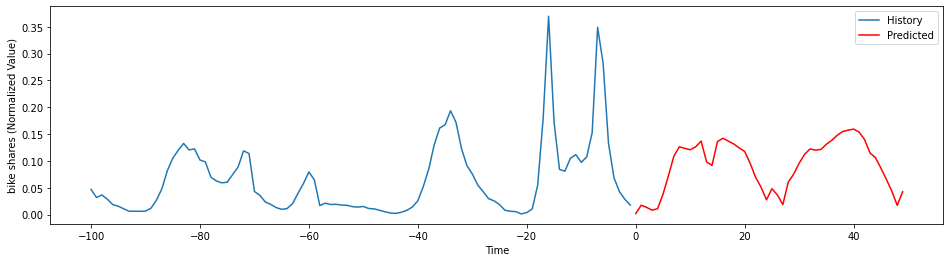

In [ ]:
plt.figure(figsize=(16,4))
num_in = create_time_steps(100)
num_out = 50
plt.plot(num_in,y_test[-100:],label='History')
plt.plot(np.arange(num_out),predictions, 'r',label='Predicted')
plt.xlabel("Time")
plt.ylabel("bike shares (Normalized Value)")
plt.legend()
plt.show()